In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

from fe_functions import single_span_girder, deform_line, moment_line

# Eingabe

In [2]:
length  = 8      # Länge Träger [m]
x_load  = 4      # Abstand Lastanfang vom eingespannten Rand [m]
n_elem  = 16      # Anzahl der Elemente [-]
EI      = 1000   # Biegesteifigkeit [kN/m**2]
p       = 10     # Last [kN/m]  

# "True" steht für "Vorhanden", "False" für "fehlt"
bearing_A  = [True, True] # vertikales Auflager, Einspannung am Punkt A
bearing_B  = [True, False] # vertikales Auflager, Einspannung am Punkt B

# Berechnung

In [3]:
elem_displace, lengths = single_span_girder(length, x_load, n_elem, EI, p, bearing_A, bearing_B)

# Ausgabe

In [4]:
x, w = deform_line(elem_displace, lengths)
x, m = moment_line(elem_displace, lengths, EI)

print(max(w))
print(max(m), min(m))

0.13858031250000705
33.02083333333478 -35.000000000002416


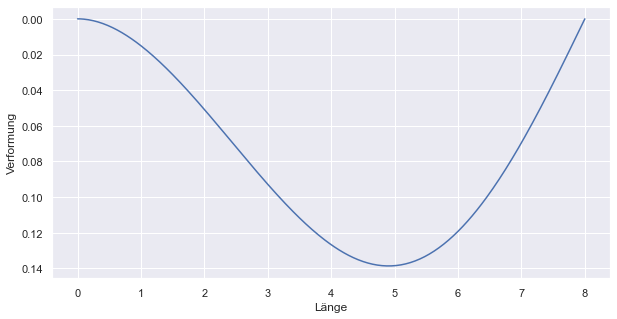

In [5]:
def draw_deform_line(elem_displace, lengths, division=20):
    x, w = deform_line(elem_displace, lengths, division)

    df = pd.DataFrame({"Länge": x, "Verformung": w})
    deform = sns.lineplot(x="Länge", y="Verformung", data=df, sort=False)
    deform = deform.invert_yaxis()

    return deform

plt.figure(figsize=(10,5))
deform_plot = draw_deform_line(elem_displace, lengths)

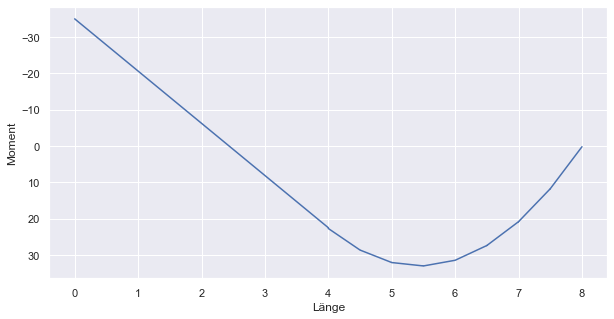

In [6]:
def draw_mom_line(elem_displace, lengths, EI, division=20):
    x, m = moment_line(elem_displace, lengths, EI, division)

    df2 = pd.DataFrame({"Länge": x, "Moment": m})
    mom = sns.lineplot(x="Länge", y="Moment", data=df2, sort=False, estimator=None)
    mom = mom.invert_yaxis()

    return mom

plt.figure(figsize=(10,5))
mom_plot = draw_mom_line(elem_displace, lengths, EI)

# Überlagerung 

In [7]:
w_list, m_list = [], []

convergence = pd.DataFrame(columns={"Elementanzahl", "w_4", "m_0", "m_4l", "m_4r", "m_8", "Wert"}, index=[2, 4, 8, 16], dtype=float)
exact_values = pd.DataFrame({"w_4": [0.12667,0.12667,0.12667,0.12667], "m_0": [-35,-35,-35,-35], "m_4l": [22.5,22.5,22.5,22.5], "m_4r": [22.5,22.5,22.5,22.5], "m_8": [0,0,0,0], "Wert": ["exakt","exakt","exakt","exakt"], "Elementanzahl": [2,4,8,16]})   # aus Ruckzuck ermittelte exakte Ergebnisse

for n in [100, 2, 4, 8, 16]:
    elem_displace, lengths = single_span_girder(length, x_load, n, EI, p, bearing_A, bearing_B)     # Berechne FE-Modell

    division = 20 if n != 100 else 5                            # kleinere Stabteilung bei 100 Elementen
    x, w = deform_line(elem_displace, lengths, division)        # berechne Verformungslinie
    x, m = moment_line(elem_displace, lengths, EI, division)    # berechne Momentenlinie

    num = [n for i in range(len(x))]                                            # Ergänze Anzahl der Elemente
    df_w = pd.DataFrame({"Länge": x, "Verformung": w, "Elementanzahl": num})
    df_m = pd.DataFrame({"Länge": x, "Moment": m, "Elementanzahl": num})
    w_list.append(df_w)
    m_list.append(df_m)
    
    if n != 100:                                        # ermittle und speichere Werte für Konvergenzbetrachtung
        convergence.at[num, "Elementanzahl"] = num
        convergence.at[num, "Wert"] = "FE"
        convergence.at[num, "w_4"] = round(df_w.loc[df_w["Länge"] == 4.0].iloc[0]["Verformung"], 5)
        convergence.at[num, "m_0"] = round(df_m.loc[df_m["Länge"] == 0.0].iloc[0]["Moment"], 5)
        convergence.at[num, "m_4l"] = round(df_m.loc[df_m["Länge"] == 4.0].iloc[0]["Moment"], 5)
        convergence.at[num, "m_4r"] = round(df_m.loc[df_m["Länge"] == 4.0].iloc[1]["Moment"], 5)
        convergence.at[num, "m_8"] = round(df_m.loc[df_m["Länge"] == 8.0].iloc[0]["Moment"], 5)

convergence = pd.concat((convergence, exact_values))

# Erzeuge Farbpalette, damit die "exakte" Lösung eine andere Farbe erhält und damit deutlich unterschieden werden kann
color_short = list(sns.color_palette("ch:s=.25,rot=-.25", n_colors=5))[0:4]     
color_short.insert(0, (139/255,195/255,74/255))
color = sns.color_palette(color_short)

## Konvergenz

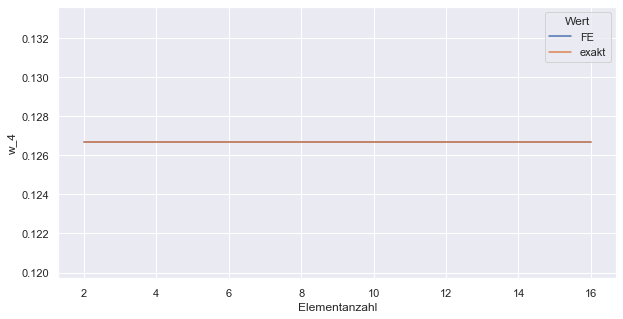

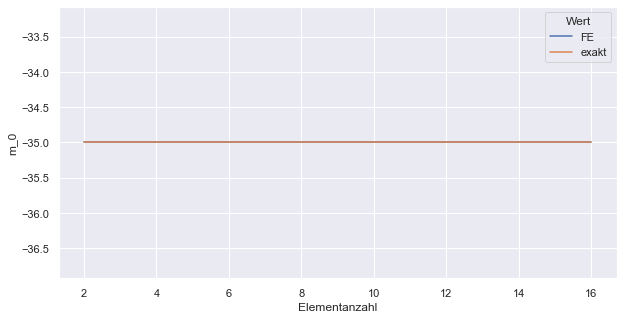

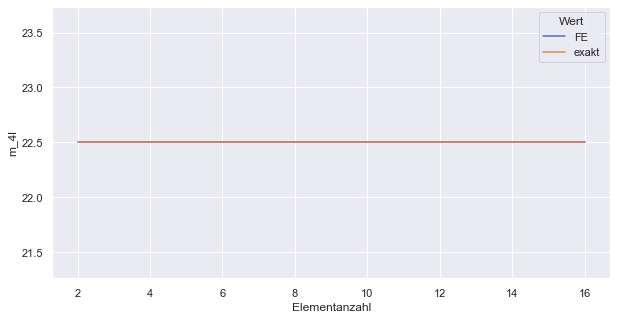

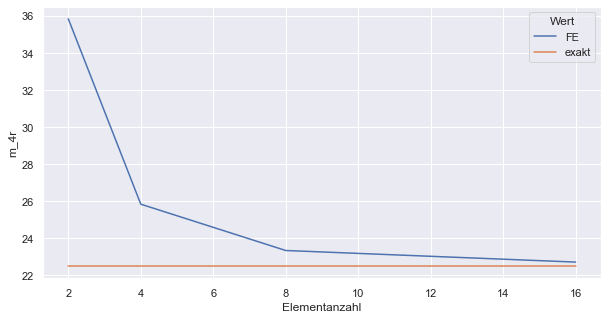

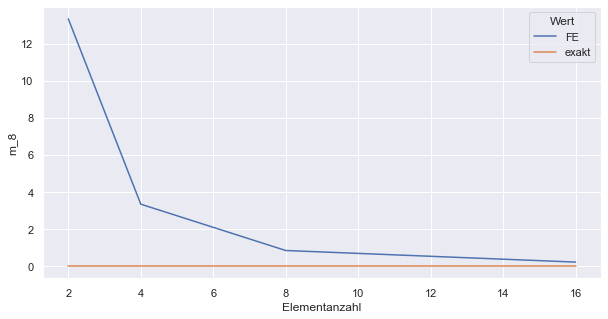

In [8]:
# Zeichne Konvergenzdarstellung
plt.figure(figsize=(10,5))
sns.lineplot(data=convergence, x="Elementanzahl", y="w_4", hue="Wert", hue_order=["FE", "exakt"])
plt.figure(figsize=(10,5))
sns.lineplot(data=convergence, x="Elementanzahl", y="m_0", hue="Wert", hue_order=["FE", "exakt"])
plt.figure(figsize=(10,5))
sns.lineplot(data=convergence, x="Elementanzahl", y="m_4l", hue="Wert", hue_order=["FE", "exakt"])
plt.figure(figsize=(10,5))
sns.lineplot(data=convergence, x="Elementanzahl", y="m_4r", hue="Wert", hue_order=["FE", "exakt"])
plt.figure(figsize=(10,5))
sns.lineplot(data=convergence, x="Elementanzahl", y="m_8", hue="Wert", hue_order=["FE", "exakt"])

## Vergleich Biege- und Momentenlinien

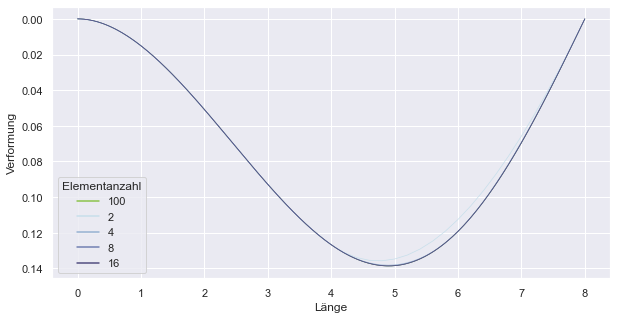

In [9]:
plt.figure(figsize=(10,5))

df3 = pd.concat(w_list)     # kombiniere einzelne DataFrames

deform_test = sns.lineplot(data=df3, x="Länge", y="Verformung", hue="Elementanzahl", hue_order=[100, 2, 4, 8, 16], sort=False, linewidth=0.7, palette=color)
deform_test.invert_yaxis()

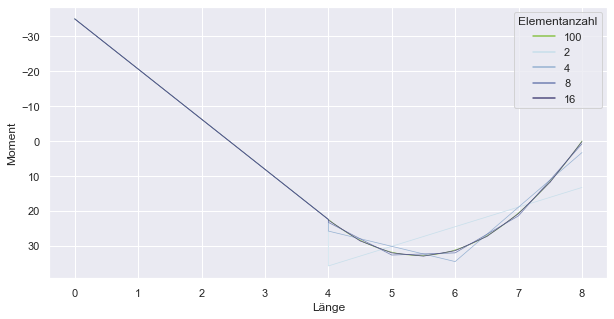

In [10]:
df4 = pd.concat(m_list)

plt.figure(figsize=(10,5))
mom_test = sns.lineplot(data=df4, x="Länge", y="Moment", hue="Elementanzahl", hue_order=[100, 2, 4, 8, 16], sort=False, estimator=None, linewidth=0.7, palette=color)
mom_test.invert_yaxis()